In [1]:
#importing required libraries

import pandas as pd
import numpy as np

from datetime import datetime  #changing str to datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import requests  #library to download files from the internet
from PIL import Image  # (pillow) library to download images from the internet
from io import BytesIO  #library which works with PIL to import images directly from the internet


from bs4 import BeautifulSoup  #library to scrap data off HTML directly
import wptools  #API for MediaWiki - API used to access data from Wikipedia


import os  #library to work with/access files in the local directories
import glob  #library to access files with particular extensions in a folder (using wildcard characters)


import wptools  #API for accessing/downloading data from wikipedia


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator  #library to create wordclouds

The purpose of this exercise is to understand how the critic ratings weigh against audience ratings for the top 100 films rated on Rotten Tomatoes and whether critic ratings should be the ultimate truth metric for a movie's success rating

The diferent stages of this exercise are as follows:
1. The exercise will start by scrapping data off the Rotten Tomato's webpage - It will scrape the data for both Crtics as well as Audience ratings
2. The Next step will be to clean and organise data in a Data Frame
3. We will also create a Data Frame containing (Ebert) reviews for the top movies. We will do this by (either downloading text files and reading data off of them, or by scrapping data directly from the webpage)
4. We will download movie posters of the top rated movie using the Media Wiki API for Wikipedia
5. We will use the critic and audience rating to plot the ratings and get a better visibility on the movie ratings (in Tableau)
6. We will create a word cloud for the top rated (both critic and audience movie) in a stencil

Stage 1: Scrapping data off the Rotten Tomato's (RT) website for the critic and audience ratings

Scrapping the URLs for each movie included in the top 100 RT list from the RT homepage

In [2]:
#URL of the top 100 rated movies on Rotten Tomatoes
url = 'https://www.rottentomatoes.com/top/bestofrt/'

In [3]:
#downloading the html of the ratings page
response = requests.get(url)

In [4]:
with open('best_of_rt.html', mode = 'wb') as file:
    file.write(response.content)

In [5]:
#creating the HTML Soup

with open('best_of_rt.html') as file:
    soup = BeautifulSoup(file, 'lxml')

In [6]:
#Using soup to find and extract the URLs for the top 100 rated movies
#the URLs are stored in a block which is a script item of type = "application/ld+json" 
#we will extract that particular block from the HTML first 

url_block = soup.find(type="application/ld+json").contents

In [7]:
#converting URL block from str to dict

import json

url_block_dict = json.loads(url_block[0])


In [8]:
#the URLs for all the top 100 movies are stored in the key 'itemListElement' which is a list of dictionaries
#we will iterate over this and extract both the position/ranking as well as the URLs for the top 100 movies

df_list = []

for i in range(len(url_block_dict['itemListElement'])):
    ranking = url_block_dict['itemListElement'][i]['position']+1
    movie_url = url_block_dict['itemListElement'][i]['url']
    df_list.append({'ranking': ranking,
                    'url': movie_url})
    

In [9]:
df_homepage = pd.DataFrame(df_list, columns = ['ranking', 'url'])

In [10]:
df_homepage.head()

ranking                                                url
0        1  https://www.rottentomatoes.com/m/black_panther...
1        2        https://www.rottentomatoes.com/m/lady_bird/
2        3  https://www.rottentomatoes.com/m/mission_impos...
3        4   https://www.rottentomatoes.com/m/blackkklansman/
4        5          https://www.rottentomatoes.com/m/get_out/

In [11]:
url_list = df_homepage['url']

In [12]:
url_list

0     https://www.rottentomatoes.com/m/black_panther...
1           https://www.rottentomatoes.com/m/lady_bird/
2     https://www.rottentomatoes.com/m/mission_impos...
3      https://www.rottentomatoes.com/m/blackkklansman/
4             https://www.rottentomatoes.com/m/get_out/
                            ...                        
95            https://www.rottentomatoes.com/m/mcqueen/
96    https://www.rottentomatoes.com/m/american_hustle/
97      https://www.rottentomatoes.com/m/the_nice_guys/
98     https://www.rottentomatoes.com/m/true_grit_2010/
99             https://www.rottentomatoes.com/m/weiner/
Name: url, Length: 100, dtype: object

We are now going to use this list to access the webpage of each individual movie and scrap the critic ratings and audience ratings from it

In [13]:
ranking = 0 
df_list = []

for url in url_list:
    ranking += 1
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'lxml')
    movie_title = soup.find('title').contents[0].split('-')[0].strip()

    score_block = json.loads(soup.find(id="score-details-json").contents[0])
    audience_count = score_block['scoreboard']['audienceCount']
    audience_score = score_block['scoreboard']['audienceScore']
    critic_count = score_block['scoreboard']['tomatometerCount']
    critic_score = score_block['scoreboard']['tomatometerScore']
    rating = score_block['scoreboard']['rating']
    
    #box_office = soup.find_all('div', class_="meta-value")[8].contents[0]

    for obj in soup.find_all('div', class_="meta-value"):
        if obj.contents[0][0] == '$':
            box_office = obj.contents[0]
    
    df_list.append({'rank': ranking,
                   'title': movie_title,
                   'audience_count' : audience_count,
                   'audience_score' : audience_score,
                   'critic_count' : critic_count,
                   'critic_score' : critic_score,
                   'movie_rating' : rating,
                   'box_office' : box_office})
    
    print(ranking)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [14]:
df_movie_details = pd.DataFrame(df_list, columns = ['rank','title','audience_count','audience_score','critic_count',
                                                    'critic_score','movie_rating','box_office'])

In [15]:
df_movie_details.head()

rank                  title  audience_count audience_score  critic_count  \
0     1   Black Panther (2018)           88211             79           525   
1     2       Lady Bird (2017)           22958             79           398   
2     3    Mission: Impossible           16444             88           435   
3     4  BlacKkKlansman (2018)           11656             83           446   
4     5         Get Out (2017)           76104             86           397   

  critic_score movie_rating box_office  
0           96        PG-13    $700.2M  
1           99            R     $48.9M  
2           97        PG-13    $220.1M  
3           96            R     $48.6M  
4           98            R    $176.0M

In [16]:
df_movie_details.sample(7)

rank                          title  audience_count audience_score  \
59    60  Avengers: Infinity War (2018)           60002             91   
2      3            Mission: Impossible           16444             88   
12    13                 Dunkirk (2017)           69190             81   
98    99               True Grit (2010)          158405             85   
55    56          Phantom Thread (2017)            7969             71   
93    94             Logan Lucky (2017)           27856             76   
42    43      Hell or High Water (2016)           40241             88   

    critic_count critic_score movie_rating box_office  
59           481           85        PG-13    $678.8M  
2            435           97        PG-13    $220.1M  
12           461           92        PG-13    $188.0M  
98           275           95        PG-13    $171.0M  
55           355           91            R     $20.9M  
93           283           92        PG-13     $27.8M  
42           282           96            R     $27.0M

### Cleaning df_master

Checking for number of records and NULL values

In [17]:
df_homepage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ranking  100 non-null    int64 
 1   url      100 non-null    object
dtypes: int64(1), object(1)
memory usage: 1.7+ KB


In [18]:
df_movie_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   rank            100 non-null    int64 
 1   title           100 non-null    object
 2   audience_count  100 non-null    int64 
 3   audience_score  100 non-null    object
 4   critic_count    100 non-null    int64 
 5   critic_score    100 non-null    object
 6   movie_rating    100 non-null    object
 7   box_office      100 non-null    object
dtypes: int64(3), object(5)
memory usage: 6.4+ KB


There are 100 records in both **df_homepage** and **df_movie_details**. There are **no NULL values** in any of the columns

Checking for **duplicated** records

In [19]:
df_homepage.duplicated().sum()

0

In [20]:
df_movie_details.duplicated().sum()

0

There are **no Duplicated** records in either of the tables

**Data Points to be cleaned:**

1. Title column has year included - should only be title with separate column for year of release
2. box_office column is of type str - should be type float
3. There are two DataFrames with information about same movies sitting in both DFs - should be one Master DataFrame
4. Rank 3: Mission Impossible does not have a release year (might be multiple movies without year of release mentioned) - add year of release
5. Rank 36: Spider - Movie name seems incorrect - correct movie name
6. Rank 6: Spider - Movie name seems incorrect - correct movie name
7. Rank 64: Ant - Movie name seems incorrect - correct movie name
8. Rank 22 and Rank 88 have incorrect box_office earning values - correct box office earning value
9. Audience Score and Critic Score are type Str - Should be type Int
10. Rank 94: Only Yesterday - Movie rating missing - add 'no_rating' 
11. Movie Ratings are str - should be categorical dtypes
12. Rank 42: Blade Runner 2049 - Year of Release is 2049 (well into the future) - correct year of release

**1. Combine two DataFrames into one master DataFrame.**

There are now 2 DataFrames; **df_homepage** and **df_movie_details**

We will combine them to a master DataFrame i.e. **df_master**

The *df_master* will have all the info of *df_movie_details* as well as the movie homepage URLs which will be pulled from *df_homepage*

In [21]:
df_homepage.head()

ranking                                                url
0        1  https://www.rottentomatoes.com/m/black_panther...
1        2        https://www.rottentomatoes.com/m/lady_bird/
2        3  https://www.rottentomatoes.com/m/mission_impos...
3        4   https://www.rottentomatoes.com/m/blackkklansman/
4        5          https://www.rottentomatoes.com/m/get_out/

In [22]:
df_movie_details.head()

rank                  title  audience_count audience_score  critic_count  \
0     1   Black Panther (2018)           88211             79           525   
1     2       Lady Bird (2017)           22958             79           398   
2     3    Mission: Impossible           16444             88           435   
3     4  BlacKkKlansman (2018)           11656             83           446   
4     5         Get Out (2017)           76104             86           397   

  critic_score movie_rating box_office  
0           96        PG-13    $700.2M  
1           99            R     $48.9M  
2           97        PG-13    $220.1M  
3           96            R     $48.6M  
4           98            R    $176.0M

In [23]:
#renaming 'rank' column in df_movie_details to 'ranking' to allow for joining of the two tables

df_movie_details.rename(columns = {'rank' : 'ranking'}, inplace = True)

In [24]:
df_movie_details.head(2)

ranking                 title  audience_count audience_score  critic_count  \
0        1  Black Panther (2018)           88211             79           525   
1        2      Lady Bird (2017)           22958             79           398   

  critic_score movie_rating box_office  
0           96        PG-13    $700.2M  
1           99            R     $48.9M

In [25]:
#joining/merging two dataframes on common key: 'rank' = 'ranking'

df_master = pd.merge(df_movie_details, df_homepage, on = 'ranking', how = 'inner')

In [26]:
df_master.head()

ranking                  title  audience_count audience_score  \
0        1   Black Panther (2018)           88211             79   
1        2       Lady Bird (2017)           22958             79   
2        3    Mission: Impossible           16444             88   
3        4  BlacKkKlansman (2018)           11656             83   
4        5         Get Out (2017)           76104             86   

   critic_count critic_score movie_rating box_office  \
0           525           96        PG-13    $700.2M   
1           398           99            R     $48.9M   
2           435           97        PG-13    $220.1M   
3           446           96            R     $48.6M   
4           397           98            R    $176.0M   

                                                 url  
0  https://www.rottentomatoes.com/m/black_panther...  
1        https://www.rottentomatoes.com/m/lady_bird/  
2  https://www.rottentomatoes.com/m/mission_impos...  
3   https://www.rottentomatoes.com/m/blackkklansman/  
4          https://www.rottentomatoes.com/m/get_out/

Making a copy of the **master data frame (df_master)** for cleaning

In [27]:
df_clean = df_master.copy()

In [28]:
df_clean.head(2)

ranking                 title  audience_count audience_score  critic_count  \
0        1  Black Panther (2018)           88211             79           525   
1        2      Lady Bird (2017)           22958             79           398   

  critic_score movie_rating box_office  \
0           96        PG-13    $700.2M   
1           99            R     $48.9M   

                                                 url  
0  https://www.rottentomatoes.com/m/black_panther...  
1        https://www.rottentomatoes.com/m/lady_bird/

**2. "Title" column has year included in it**

Remove year from title column and add it into a new/separate column

In [29]:
df_clean['year_of_release'] = df_clean['title'].str.extract(pat = '(\d\d\d\d)')

In [30]:
df_clean.head(2)

ranking                 title  audience_count audience_score  critic_count  \
0        1  Black Panther (2018)           88211             79           525   
1        2      Lady Bird (2017)           22958             79           398   

  critic_score movie_rating box_office  \
0           96        PG-13    $700.2M   
1           99            R     $48.9M   

                                                 url year_of_release  
0  https://www.rottentomatoes.com/m/black_panther...            2018  
1        https://www.rottentomatoes.com/m/lady_bird/            2017

In [31]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ranking          100 non-null    int64 
 1   title            100 non-null    object
 2   audience_count   100 non-null    int64 
 3   audience_score   100 non-null    object
 4   critic_count     100 non-null    int64 
 5   critic_score     100 non-null    object
 6   movie_rating     100 non-null    object
 7   box_office       100 non-null    object
 8   url              100 non-null    object
 9   year_of_release  96 non-null     object
dtypes: int64(3), object(7)
memory usage: 8.6+ KB


**3. Correcting Movie names and adding missing release date**

There are *4 entries/movies* with no year of release date mentioned

In [32]:
#identifying the 4 movie titles without any year of release mentioned

df_clean[df_clean['year_of_release'].isnull()]

ranking                title  audience_count audience_score  critic_count  \
2         3  Mission: Impossible           16444             88           435   
6         7               Spider           21106             93           391   
35       36               Spider          108811             87           393   
63       64                  Ant           25211             75           435   

   critic_score movie_rating box_office  \
2            97        PG-13    $220.1M   
6            97           PG    $190.2M   
35           92        PG-13    $334.4M   
63           87        PG-13    $216.6M   

                                                  url year_of_release  
2   https://www.rottentomatoes.com/m/mission_impos...             NaN  
6   https://www.rottentomatoes.com/m/spider_man_in...             NaN  
35  https://www.rottentomatoes.com/m/spider_man_ho...             NaN  
63  https://www.rottentomatoes.com/m/ant_man_and_t...             NaN

The **movie title** and the **year of release** for these 4 movies will be extracted manually by browsing to the movie *URLs* included in the table

In [33]:
#changing pandas display options so that the whole URL is visible 

pd.set_option('display.max_colwidth', None)

In [34]:
#extracting the URLs for the records with missing/NULL year of release

df_clean[df_clean['year_of_release'].isnull()].url

2           https://www.rottentomatoes.com/m/mission_impossible_fallout/
6     https://www.rottentomatoes.com/m/spider_man_into_the_spider_verse/
35               https://www.rottentomatoes.com/m/spider_man_homecoming/
63                https://www.rottentomatoes.com/m/ant_man_and_the_wasp/
Name: url, dtype: object

From the URLs we can manually check the correct titles and release years for the 4 entries:

1. (ranking 3) Mission: Impossible - *Correct Title* =  **Mission: Impossible -- Fallout**; *Correct Year of Release* = **2018**
2. (ranking 6) Spider - *Correct Title* =  **Spider-man: Into the Spider-Verse**; *Correct Year of Release* = **2018**
3. (ranking 36) Spider - *Correct Title* =  **Spider-man: Homecoming**; *Correct Year of Release* = **2017**
4. (ranking 64) Ant - *Correct Title* =  **Ant-man and the Wasp**; *Correct Year of Release* = **2018**


In [35]:
#correcting the movie titles and adding the missing year of release 

index = list(df_clean[df_clean['year_of_release'].isnull()].index)
column = ['title', 'year_of_release']

titles = ['Mission: Impossible -- Fallout', 'Spider-man: Into the Spider-Verse', 'Spider-man: Homecoming', 'Ant-man and the Wasp']
years = ['2018', '2018', '2017', '2018']

for col in column:
    for i in range(len(index)):
        if col == 'title':
            df_clean.at[index[i], col] = titles[i]
        else:
            df_clean.at[index[i], col] = years[i]

In [36]:
#checking if the values were replaced correctly 

df_clean.query('ranking in [3, 6, 36, 64]')

ranking                           title  audience_count audience_score  \
2         3  Mission: Impossible -- Fallout           16444             88   
5         6       Mad Max: Fury Road (2015)          128828             86   
35       36          Spider-man: Homecoming          108811             87   
63       64            Ant-man and the Wasp           25211             75   

    critic_count critic_score movie_rating box_office  \
2            435           97        PG-13    $220.1M   
5            427           97            R    $153.6M   
35           393           92        PG-13    $334.4M   
63           435           87        PG-13    $216.6M   

                                                             url  \
2   https://www.rottentomatoes.com/m/mission_impossible_fallout/   
5            https://www.rottentomatoes.com/m/mad_max_fury_road/   
35       https://www.rottentomatoes.com/m/spider_man_homecoming/   
63        https://www.rottentomatoes.com/m/ant_man_and_the_wasp/   

   year_of_release  
2             2018  
5             2015  
35            2017  
63            2018

In [37]:
df_clean['title'] = df_clean['title'].str.title()

In [38]:
df_clean.head()

ranking                           title  audience_count audience_score  \
0        1            Black Panther (2018)           88211             79   
1        2                Lady Bird (2017)           22958             79   
2        3  Mission: Impossible -- Fallout           16444             88   
3        4           Blackkklansman (2018)           11656             83   
4        5                  Get Out (2017)           76104             86   

   critic_count critic_score movie_rating box_office  \
0           525           96        PG-13    $700.2M   
1           398           99            R     $48.9M   
2           435           97        PG-13    $220.1M   
3           446           96            R     $48.6M   
4           397           98            R    $176.0M   

                                                            url  \
0          https://www.rottentomatoes.com/m/black_panther_2018/   
1                   https://www.rottentomatoes.com/m/lady_bird/   
2  https://www.rottentomatoes.com/m/mission_impossible_fallout/   
3              https://www.rottentomatoes.com/m/blackkklansman/   
4                     https://www.rottentomatoes.com/m/get_out/   

  year_of_release  
0            2018  
1            2017  
2            2018  
3            2018  
4            2017

Remove the *year of release* from the movie *title* column

In [39]:
#Remove the 'year of release' from the movie 'title' column

df_clean['title'] = df_clean['title'].str.replace(r'\(\d*\)', '')

<ipython-input-39-33e98e71e73d>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean['title'] = df_clean['title'].str.replace(r'\(\d*\)', '')


In [40]:
df_clean.head()

ranking                           title  audience_count audience_score  \
0        1                  Black Panther            88211             79   
1        2                      Lady Bird            22958             79   
2        3  Mission: Impossible -- Fallout           16444             88   
3        4                 Blackkklansman            11656             83   
4        5                        Get Out            76104             86   

   critic_count critic_score movie_rating box_office  \
0           525           96        PG-13    $700.2M   
1           398           99            R     $48.9M   
2           435           97        PG-13    $220.1M   
3           446           96            R     $48.6M   
4           397           98            R    $176.0M   

                                                            url  \
0          https://www.rottentomatoes.com/m/black_panther_2018/   
1                   https://www.rottentomatoes.com/m/lady_bird/   
2  https://www.rottentomatoes.com/m/mission_impossible_fallout/   
3              https://www.rottentomatoes.com/m/blackkklansman/   
4                     https://www.rottentomatoes.com/m/get_out/   

  year_of_release  
0            2018  
1            2017  
2            2018  
3            2018  
4            2017

**3a. Rank 94: Only Yesterday Movie Rating missing**

As there is no movie rating specified on the website, we will include "no_rating" in place

In [41]:
#identifying records with no movie rating

df_clean[df_clean['movie_rating']== '']

ranking            title  audience_count audience_score  critic_count  \
94       95  Only Yesterday              210             84            57   

   critic_score movie_rating box_office  \
94          100                  $27.8M   

                                                      url year_of_release  
94  https://www.rottentomatoes.com/m/only_yesterday_1991/            1991

In [42]:
#adding "no_rating" in the rating column

index = df_clean[df_clean['movie_rating']== ''].index
column = 'movie_rating'

df_clean.at[index, column] = 'no_rating'

In [43]:
df_clean.query('ranking == 94')

ranking         title  audience_count audience_score  critic_count  \
93       94  Logan Lucky            27856             76           283   

   critic_score movie_rating box_office  \
93           92        PG-13     $27.8M   

                                              url year_of_release  
93  https://www.rottentomatoes.com/m/logan_lucky/            2017

**4. Correcting the data type of 'box office' columns**

We are going to extract the numbers from the movie earnings (without the "$" sign at the start and the "M" at the end)

In [44]:
#extracting the amount every movie earned without the $ and M 

df_clean['box_office_mil_usd'] = df_clean['box_office'].str.extract(pat = '(\$(.*)M)')[1]

In [45]:
df_clean.head()

ranking                           title  audience_count audience_score  \
0        1                  Black Panther            88211             79   
1        2                      Lady Bird            22958             79   
2        3  Mission: Impossible -- Fallout           16444             88   
3        4                 Blackkklansman            11656             83   
4        5                        Get Out            76104             86   

   critic_count critic_score movie_rating box_office  \
0           525           96        PG-13    $700.2M   
1           398           99            R     $48.9M   
2           435           97        PG-13    $220.1M   
3           446           96            R     $48.6M   
4           397           98            R    $176.0M   

                                                            url  \
0          https://www.rottentomatoes.com/m/black_panther_2018/   
1                   https://www.rottentomatoes.com/m/lady_bird/   
2  https://www.rottentomatoes.com/m/mission_impossible_fallout/   
3              https://www.rottentomatoes.com/m/blackkklansman/   
4                     https://www.rottentomatoes.com/m/get_out/   

  year_of_release box_office_mil_usd  
0            2018              700.2  
1            2017               48.9  
2            2018              220.1  
3            2018               48.6  
4            2017              176.0

In [46]:
#checking if all the values were extracted properly

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ranking             100 non-null    int64 
 1   title               100 non-null    object
 2   audience_count      100 non-null    int64 
 3   audience_score      100 non-null    object
 4   critic_count        100 non-null    int64 
 5   critic_score        100 non-null    object
 6   movie_rating        100 non-null    object
 7   box_office          100 non-null    object
 8   url                 100 non-null    object
 9   year_of_release     100 non-null    object
 10  box_office_mil_usd  98 non-null     object
dtypes: int64(3), object(8)
memory usage: 13.4+ KB


It seems like there were two values which were not extracted properly in the new column

the *box_office_clean* column has 2 NULL values which were not present in the original *box_office* column

In [47]:
#identiying NULL values in 'box_office_clean' column

df_clean[df_clean['box_office_mil_usd'].isnull()]

ranking                          title  audience_count audience_score  \
21       22  Star Wars: The Force Awakens           235718             85   
87       88                  A Separation            22911             92   

    critic_count critic_score movie_rating box_office  \
21           443           93        PG-13       $123   
87           179           99        PG-13    $331.7K   

                                                                          url  \
21  https://www.rottentomatoes.com/m/star_wars_episode_vii_the_force_awakens/   
87                        https://www.rottentomatoes.com/m/a_separation_2011/   

   year_of_release box_office_mil_usd  
21            2015                NaN  
87            2011                NaN

Two movies seem to have had incorrect *box office earning values* from the data scrapping phase. 

We are going to extract the actual box_office earning values *manually* from the URLs of the movies and add them to the table

**4a. Correcting box office earning values**

In [48]:
#getting the URLs for the required movies

df_clean[df_clean['box_office_mil_usd'].isnull()].url

21    https://www.rottentomatoes.com/m/star_wars_episode_vii_the_force_awakens/
87                          https://www.rottentomatoes.com/m/a_separation_2011/
Name: url, dtype: object

Correct values for box_office_earnings
1. STAR WARS: THE FORCE AWAKENS (ranking: 22) - USD247 Million (value extracted from Google)
2. A SEPARATION (ranking 88) - USD24.4 Million (value extracted from Google) 

In [49]:
# adding the correct the values for box_office_mil_usd in the table

index = list(df_clean[df_clean['box_office_mil_usd'].isnull()].index)
column = 'box_office_mil_usd'

values = ['247', '24.4']

for i in range(len(index)):
    df_clean.at[index[i], column] = values[i]

In [50]:
#checking if the values were entered correctly

df_clean.query('ranking in [22, 88]')

ranking                          title  audience_count audience_score  \
21       22  Star Wars: The Force Awakens           235718             85   
87       88                  A Separation            22911             92   

    critic_count critic_score movie_rating box_office  \
21           443           93        PG-13       $123   
87           179           99        PG-13    $331.7K   

                                                                          url  \
21  https://www.rottentomatoes.com/m/star_wars_episode_vii_the_force_awakens/   
87                        https://www.rottentomatoes.com/m/a_separation_2011/   

   year_of_release box_office_mil_usd  
21            2015                247  
87            2011               24.4

In [51]:
#dropping the column 'box_office' from the table as it is now redundant

df_clean.drop(columns = 'box_office', axis = 1, inplace = True)

In [52]:
df_clean.head()

ranking                           title  audience_count audience_score  \
0        1                  Black Panther            88211             79   
1        2                      Lady Bird            22958             79   
2        3  Mission: Impossible -- Fallout           16444             88   
3        4                 Blackkklansman            11656             83   
4        5                        Get Out            76104             86   

   critic_count critic_score movie_rating  \
0           525           96        PG-13   
1           398           99            R   
2           435           97        PG-13   
3           446           96            R   
4           397           98            R   

                                                            url  \
0          https://www.rottentomatoes.com/m/black_panther_2018/   
1                   https://www.rottentomatoes.com/m/lady_bird/   
2  https://www.rottentomatoes.com/m/mission_impossible_fallout/   
3              https://www.rottentomatoes.com/m/blackkklansman/   
4                     https://www.rottentomatoes.com/m/get_out/   

  year_of_release box_office_mil_usd  
0            2018              700.2  
1            2017               48.9  
2            2018              220.1  
3            2018               48.6  
4            2017              176.0

**4b. changing dtype of *box_office_mil_usd* from str to float**

In [53]:
df_clean['box_office_mil_usd'] = df_clean['box_office_mil_usd'].astype(float)

**5. Change dtype of *year_of_release* from str to int**

We are converting all the release year values to *int* instead of *datetime* because only the year of release is given (not the whole date). converting this to datetime will return a date of 1st Jan of that particular year.

In [54]:
df_clean['year_of_release'] = df_clean['year_of_release'].astype(int)

**6. Change dtype of *audience_score* and *critic_score* from str to int**

In [55]:
#changing audience score from str to int

df_clean['audience_score'] = df_clean['audience_score'].astype(int)

#changing critic score from str to int

df_clean['critic_score'] = df_clean['critic_score'].astype(int)

**7. Change dtype of *movie_rating* from str to categorical**

In [56]:
ratings = ['G', 'PG', 'PG-13', 'R', 'no_rating']

a = pd.api.types.CategoricalDtype(ordered = True, categories = ratings)

df_clean['movie_rating'] = df_clean['movie_rating'].astype(a) 

In [57]:
#checking if the dtypes were changed successfully

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   ranking             100 non-null    int64   
 1   title               100 non-null    object  
 2   audience_count      100 non-null    int64   
 3   audience_score      100 non-null    int32   
 4   critic_count        100 non-null    int64   
 5   critic_score        100 non-null    int32   
 6   movie_rating        100 non-null    category
 7   url                 100 non-null    object  
 8   year_of_release     100 non-null    int32   
 9   box_office_mil_usd  100 non-null    float64 
dtypes: category(1), float64(1), int32(3), int64(3), object(2)
memory usage: 11.0+ KB


**8. Correct year of release for rank 42: Blade Runner 2049**

The correct year of release for Blade Runner 2049 is **2017**. However, the data scrapping has its date as *2049* (which is well into the future)

In [58]:
#identifying the record with incorrect release year value

df_clean.query('year_of_release == 2049')

ranking               title  audience_count  audience_score  critic_count  \
41       42  Blade Runner 2049            51454              81           441   

    critic_score movie_rating  \
41            88            R   

                                                    url  year_of_release  \
41  https://www.rottentomatoes.com/m/blade_runner_2049/             2049   

    box_office_mil_usd  
41                91.5

In [59]:
#correct year of release to 2017

index = df_clean.query('year_of_release == 2049').index
column = 'year_of_release'

df_clean.at[index, column] = 2017

## The dataset is now ready for Analysis

In [60]:
df_clean.describe()

ranking  audience_count  audience_score  critic_count  critic_score  \
count  100.000000    1.000000e+02      100.000000    100.000000    100.000000   
mean    50.500000    4.268158e+05       82.500000    334.850000     94.230000   
std     29.011492    3.329333e+06        8.551094     87.980528      3.302448   
min      1.000000    2.100000e+02       42.000000     57.000000     85.000000   
25%     25.750000    2.070125e+04       79.000000    280.500000     92.000000   
50%     50.500000    5.792150e+04       85.000000    330.000000     94.500000   
75%     75.250000    1.035475e+05       88.000000    393.250000     97.000000   
max    100.000000    3.335686e+07       94.000000    525.000000    100.000000   

       year_of_release  box_office_mil_usd  
count       100.000000          100.000000  
mean       2015.150000          138.903000  
std           3.537319          164.860142  
min        1991.000000            1.300000  
25%        2014.000000           25.550000  
50%        2016.000000           55.400000  
75%        2017.000000          215.625000  
max        2018.000000          700.200000

**1. Audience Score vs Critic Score**

Let us investigate how the *scores* given to movies compare between Audiences and Critics

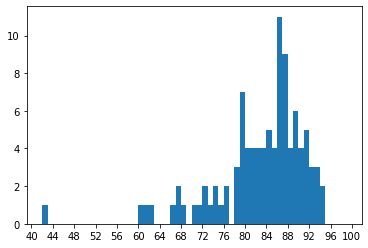

In [61]:
#histogram of the audience score

bin_edges = np.arange(df_clean['audience_score'].min(), 100, 1)

plt.hist(data = df_clean, x = 'audience_score', bins = bin_edges)

plt.xticks(np.arange(40, 101, 4));

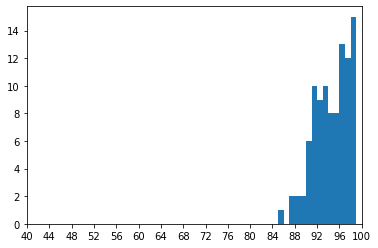

In [62]:
#histogram of the critic score

bin_edges = np.arange(df_clean['critic_score'].min(), 100, 1)

plt.hist(data = df_clean, x = 'critic_score', bins = bin_edges)

plt.xticks(np.arange(40, 101, 4));

''

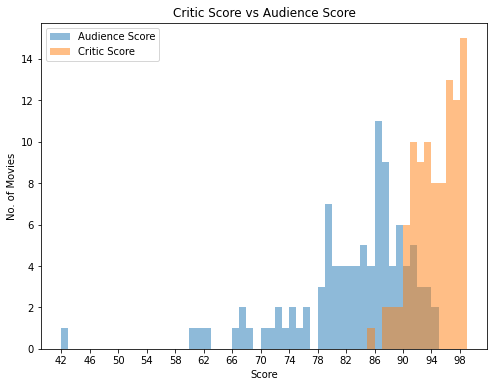

In [63]:
#histogram of the audience vs critic score

plt.figure(figsize = [8,6])

bin_edges = np.arange(df_clean['audience_score'].min(), 100, 1)

plt.hist(data = df_clean, x = 'audience_score', bins = bin_edges, alpha = 0.5)

plt.hist(data = df_clean, x = 'critic_score', bins = bin_edges, alpha = 0.5)

plt.xticks(np.arange(df_clean['audience_score'].min(), 101, 4))

plt.xlabel('Score')
plt.ylabel('No. of Movies')

plt.legend(('Audience Score', 'Critic Score'))

plt.title('Critic Score vs Audience Score')
;

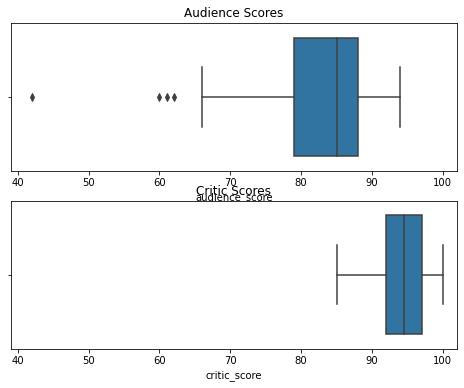

In [64]:
plt.figure(figsize = [8,6])

plt.subplot(2,1,1) #critic score

box_1 = sns.boxplot(data = df_clean, x = 'audience_score')
plt.title('Audience Scores');
plt.xlim(df_clean['audience_score'].min()-3, 102)

plt.subplot(2,1,2) #audience score

box_2 = sns.boxplot(data = df_clean, x = 'critic_score')
plt.title('Critic Scores')
plt.xlim(box_1.get_xlim());

The box and whisker plot for the *Audience* vs *Critic* scores summarizes the disparity between them very clearly. 
The **min critic score 85** which is higher than the **avg audience score 82.5**.

The *Audience scores* averaged at **82.5** have a higher spread than the critic scores with an std of *8.6* compared to *3.3* for critic scores.

Half (50%) of the *Audience Scores* are in the range of **79 to 88**. The maximum Audience Score for any movie in the RT top 100 was **94**. This is less than the **mean critic score of 94.2**.

There is also a sizable number of movies which received an Audience score of **less than 78** with the lowest score being **49**


The **avg** *Critic score* is **94.2**. They are more compactly spread with an std of *3.3*

It is visibile that the audiences and critics *do not see eye to eye* when scoring the movies. It will be interesting to see which movies do critics and audiences differ in their views about the most

**2. No. of Movies per *year* and per *rating***

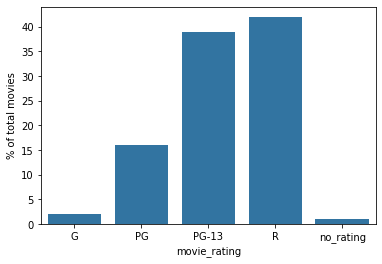

In [65]:
#plotting a bar chart for number of movies per rating

base_color = sns.color_palette()[0]

sns.countplot(data = df_clean, x = 'movie_rating', color = base_color)

plt.ylabel('% of total movies');

**R Rated movies** made up the highest proportion of movies in the RT top 100 closely followed by **PG-13**. 
Together, the R and PG-13 rated movies made up almost **81%** of total movies in the RT top 100 list. 

**PG Rated** movies made up only **16%** while **2%** were **G rated**. **1%** movies were without any rating

<AxesSubplot:xlabel='year_of_release', ylabel='count'>

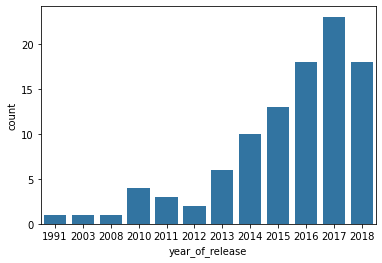

In [66]:
#plotting a bar chart for number of movies per year

sns.countplot(data = df_clean, x = 'year_of_release', color = base_color)

''

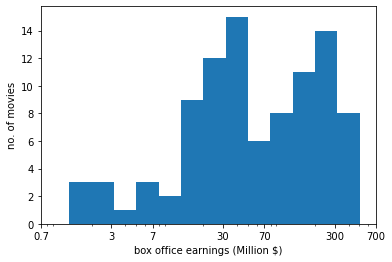

In [67]:
#plotting a histogram for number of movies per box_office earnings

bin_edges = 10**np.arange(0.1, 2.9, 0.2)

plt.hist(data = df_clean, x = 'box_office_mil_usd', bins = bin_edges)

plt.xlabel('box office earnings (Million $)')
plt.ylabel('no. of movies')

plt.xscale('log')

xticks = [0.7, 3, 7, 30, 70, 300, 700]
plt.xticks(xticks, labels = ['{}'.format(v) for v in xticks])
;

**Plotting Audience Scores vs Critic Scores**

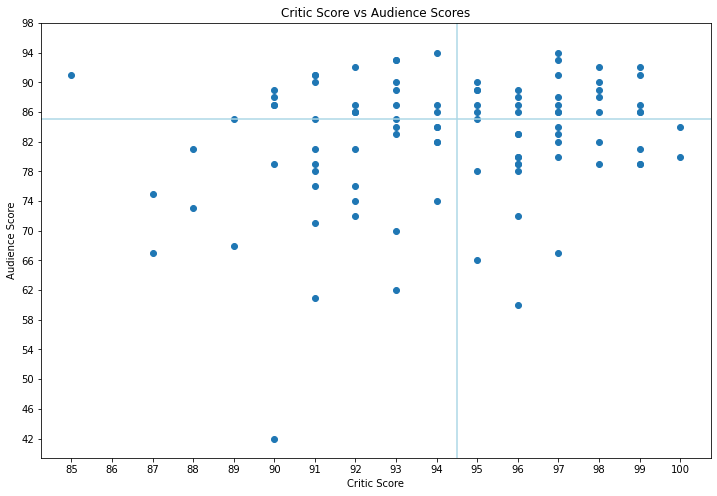

In [68]:
plt.figure(figsize = [12,8])

plt.scatter(data = df_clean, x = 'critic_score', y = 'audience_score')

plt.axvline(x = df_clean['critic_score'].median(), color = 'lightblue')
plt.axhline(y = df_clean['audience_score'].median(), color = 'lightblue')

plt.xticks(np.arange(df_clean['critic_score'].min(), 101, 1))
plt.yticks(np.arange(df_clean['audience_score'].min(), 100, 4))

plt.xlabel('Critic Score')
plt.ylabel('Audience Score')

plt.title('Critic Score vs Audience Scores');

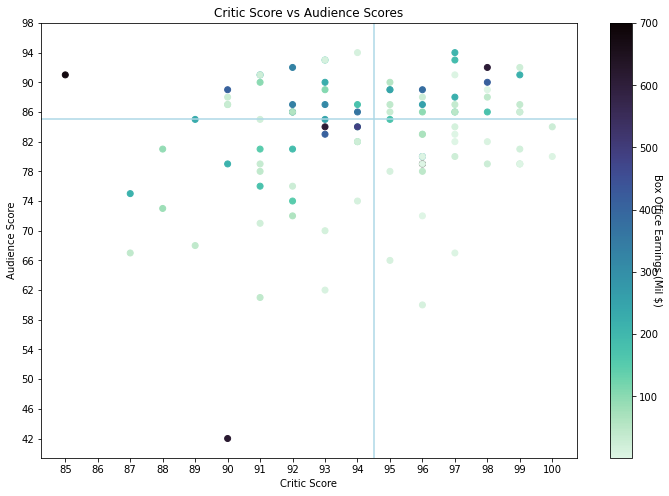

In [69]:
## Audience Score vs Critic Score with the box_office earnings color coded

plt.figure(figsize = [12,8])

plt.scatter(data = df_clean, x = 'critic_score', y = 'audience_score', c = 'box_office_mil_usd', cmap = 'mako_r')

plt.axvline(x = df_clean['critic_score'].median(), color = 'lightblue')
plt.axhline(y = df_clean['audience_score'].median(), color = 'lightblue')

plt.xticks(np.arange(df_clean['critic_score'].min(), 101, 1))
plt.yticks(np.arange(df_clean['audience_score'].min(), 100, 4))

plt.xlabel('Critic Score')
plt.ylabel('Audience Score')

plt.colorbar().set_label('Box Office Earnings (Mil $)', rotation=270)



plt.title('Critic Score vs Audience Scores');

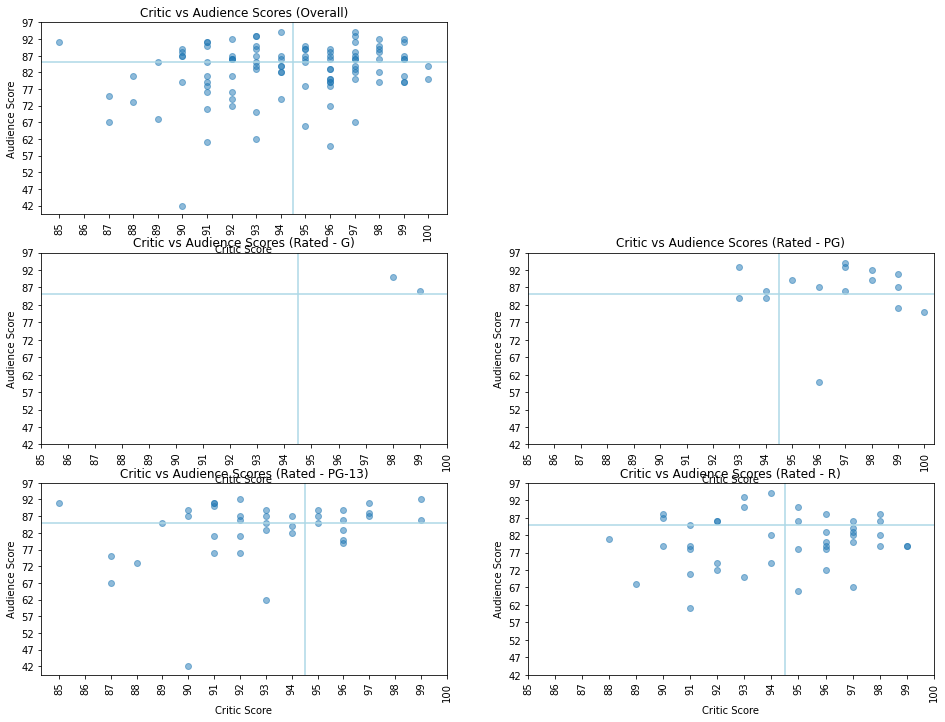

In [70]:
plt.figure(figsize = [16,12])

#plotting critic vs audience score for all movies ratings together in one plot

plt.subplot(3,2,1)

plt.scatter(data = df_clean, x = 'critic_score', y = 'audience_score', alpha = 0.5)

plt.axvline(x = df_clean['critic_score'].median(), color = 'lightblue')
plt.axhline(y = df_clean['audience_score'].median(), color = 'lightblue')

plt.xticks(np.arange(df_clean['critic_score'].min(), 101, 1), rotation = 90)
plt.yticks(np.arange(df_clean['audience_score'].min(), 100, 5))

plt.xlabel('Critic Score')
plt.ylabel('Audience Score')
plt.title('Critic vs Audience Scores (Overall)')


######

#plotting critic vs audience score with each movie rating in a separate subplot

ratings = ['G', 'PG', 'PG-13', 'R']

for i in range(len(ratings)):
    
    plt.subplot(3,2,3+i)
    
    rating = ratings[i]
    
    plt.scatter(data = df_clean.query('movie_rating == @rating'), x = 'critic_score', y = 'audience_score', alpha = 0.5)

    plt.axvline(x = df_clean['critic_score'].median(), color = 'lightblue')
    plt.axhline(y = df_clean['audience_score'].median(), color = 'lightblue')

    plt.xticks(np.arange(df_clean['critic_score'].min(), 101, 1), rotation = 90)
    plt.yticks(np.arange(df_clean['audience_score'].min(), 100, 5))

    plt.xlabel('Critic Score')
    plt.ylabel('Audience Score')
    plt.title('Critic vs Audience Scores (Rated - {})'.format(rating))



From the above scatter plots above represent Audience scores vs Critic Scores for every movie in the RT top 100 list. The lines are drawn on *median* scores for both axis and divide the plot into 4 quadrants. 

The movies in the *top right quadrant* are the critically acclaimed and popularly loved movies. They are rated highly by both the critics and audiences. For our analysis, movies in the top right quadrant make up the select list of **truly great movies***

It is quite clear that Audiences are not always on the same page as the Critics. There are a number of movies which the Critics have rated highly whereas the Audiences have rated poorly i.e. **Critically Overrated** movies (*bottom right quadrant*).

At the same time there are movies which the Critics have rated poorly but the Audiences have rated highly i.e. **Critically Underrated** movies (*top left quadrant).

The Audiences and Critics agree in their scoring for movies which are **rated G** and, to some extent, **rated PG** as well.

However, their differences are amplified when scoring movies which are rated **PG-13** and **R**. 

As movies rated PG-13 and R make up more than *80%* of all movies in the RT top 100 list, it is safe to assume that Audiences and Critics are not on the same page when scoring movies. 

**Confidence Interval Test - Difference in Means** 

To be sure that the Audience Scores are always inconsistent with the Critic Scores, we will run a **confidence interval test** for the difference in means of Audience Scores and Critic Scores.

In [71]:
#running a confidence interval test for difference in means of Audience Scores and Critic Scores

diff_actual = df_clean['audience_score'].mean() - df_clean['critic_score'].mean()
diff_actual

-11.730000000000004

The actual difference of means between the *audience score* and the *critic score* for this RT top 100 list is **-11.74**

In [72]:
#creating a sampling distribution for difference in means

diff = []

for _ in range(10000):
    boot_sample = df_clean.sample(100, replace = True)
    mean_audience = boot_sample['audience_score'].mean()
    mean_critic = boot_sample['critic_score'].mean()
    diff_mean = mean_audience - mean_critic
    diff.append(diff_mean)

In [73]:
#range of difference in mean with 99% confidence interval

np.percentile(diff, 0.5), np.percentile(diff, 99.5)

(-13.939999999999998, -9.659900000000013)

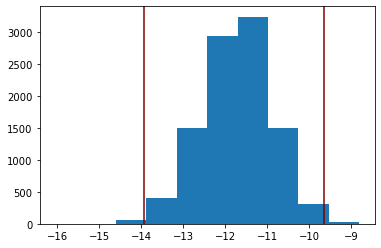

In [74]:
#visual representation of difference in means

plt.hist(diff)

plt.axvline(np.percentile(diff, 0.5), color = 'maroon')
plt.axvline(np.percentile(diff, 99.5), color = 'maroon');

It can be said with **99%** confidence that the *audience score means* will be between *9.57* and *14.06* **less** than the *critic score means*

So its quite evident that Audiences and Critics do not see eye to eye when rating movies. But who's ratings should we follow if we were to choose one of the two. 

We can take **box office earnings** as a metric. Movies, while a form of art, are majorly a commercial project. The amount of revenue they bring in does contribute to how successful they are viewed by the majority. 

Let us investigate if *Critic or Audience scores have any relationship with the revenue the movies earn.*

**Investigating if box office earnings have any relationship with Critic Scores**

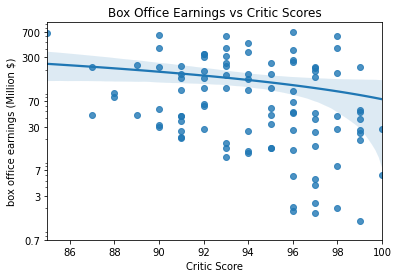

In [75]:
sns.regplot(data = df_clean, x = 'critic_score', y = 'box_office_mil_usd')

plt.yscale('log')

yticks = [0.7, 3, 7, 30, 70, 300, 700]
plt.yticks(yticks, labels = ['{}'.format(v) for v in xticks])

plt.ylabel('box office earnings (Million $)')
plt.xlabel('Critic Score')

plt.title('Box Office Earnings vs Critic Scores');

In [76]:
#caclulating the correlation coefficient between Critic Scores and Box office earnings

critic_score = df_clean['critic_score']
box_office = df_clean['box_office_mil_usd']

corr_critic_earning = critic_score.corr(box_office)
print('The correlation between Critic Scores and Box Office earnings has a coefficient of {}'.format(corr_critic_earning))

The correlation between Critic Scores and Box Office earnings has a coefficient of -0.22316925054318976


The trend seen from the scatter plot is that movies which are rated **higher** by the *critics* tend to earn **less** on the box office. This is confirmed with a *negative* correlation coefficient between critic ratings and box office earnings

**Investigating if box office earnings have any relationship with Audience Scores**

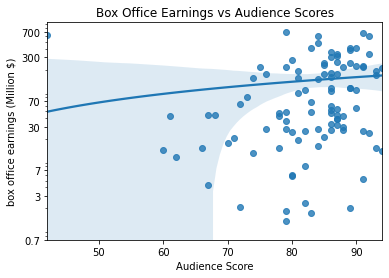

In [77]:
sns.regplot(data = df_clean, x = 'audience_score', y = 'box_office_mil_usd')

plt.yscale('log')

yticks = [0.7, 3, 7, 30, 70, 300, 700]
plt.yticks(yticks, labels = ['{}'.format(v) for v in xticks])

plt.ylabel('box office earnings (Million $)')
plt.xlabel('Audience Score')

plt.title('Box Office Earnings vs Audience Scores');

In [78]:
audience_score = df_clean['audience_score']
box_office = df_clean['box_office_mil_usd']

corr_audience_earning = audience_score.corr(box_office)
print('The correlation between Audience Scores and Box Office earnings has a coefficient of {}'.format(corr_audience_earning))

The correlation between Audience Scores and Box Office earnings has a coefficient of 0.11470351523227858


The trend seen from the scatter plot is that movies which are rated **higher** by the *audiences* tend to earn **more** on the box office. This is confirmed with a *positive* correlation coefficient between critic ratings and box office earnings

In [79]:
#saving the df_clean as a csv file on the local directory

df_clean.to_csv('rt100_clean.csv', index = False)

### Conclusion

An analysis of the scores for the RT top 100 rated movies was performed to see how significant *Critic* scores are in the modern era of mass communication. 

Critic Scores were weighed against Audience Scores and it was observed that *Audiences and Critics are not on the same page* when rating RT top 100 movies. In fact Audience Ratings are *9.57 to 14.06* points *less* than Critic Ratings with 99% certainity. 

Box office earnings was used as a metric to define which group (audiences or critics) was more credible in defining how 'successful' a movie had been. 

It was observed that higher *critic* ratings would bring in less box office earnings, whereas higher *audience* ratings would bring in higher box office earnings.

It was concluded that while critic ratings hold their weight, they have become less significant in today's age of mass communication where the audiences have a very active platform to voice their opinion. The RT top 100 list should incorporate audience rating as well as critic rating to rate the **real top 100 movies**

**Extra: Top Rated Movie Word Cloud & Poster**

We will be creating a word cloud for the top rated (both Audiences and Critics) movie.

We will get the text of the word cloud for a *Roger Eberts* review

In [80]:
##identifying the top rated movie

df_clean.query('critic_score == 99 & audience_score > 91')

ranking          title  audience_count  audience_score  critic_count  \
87       88  A Separation            22911              92           179   

    critic_score movie_rating  \
87            99        PG-13   

                                                    url  year_of_release  \
87  https://www.rottentomatoes.com/m/a_separation_2011/             2011   

    box_office_mil_usd  
87                24.4

The movie **A Separation** released in year 2011 was found to be the *top rated movie* both by critics as well as audiences. The movie earned USD 24.4 Million on the box office.

In [81]:
#making the soup (for extraction of the review directly from the webpage)

url_review = 'https://www.rogerebert.com/reviews/a-separation-2012'

response = requests.get(url_review)
soup = BeautifulSoup(response.content, 'lxml')

In [82]:
#extracting the review from the webpage contents

review_text = []

#the review has 3 excerpts, so we will extract them separately and then combine them together in a single str

excerpt_1 = soup.find_all('section', class_ = 'page-content--block_editor-content js--reframe')[0].contents[1].contents[0]

review_text.append(excerpt_1)

In [83]:
excerpt_2 = soup.find_all('section', class_ = 'page-content--block_editor-content js--reframe')[1].contents

for text in excerpt_2:
    try:
        text_1 = text.contents
        for txt in text_1:
            try:
                review_text.append(txt.contents)
            except:
                review_text.append(txt)  
    except:
        continue

In [84]:
excerpt_3 = soup.find_all('section', class_ = 'page-content--block_editor-content js--reframe')[2].contents[1].contents[0]

review_text.append(excerpt_3)

In [85]:
#combining all the exceprts into a single str

review = ''

for text in review_text:
    review = review + ' ' + str(text)


**Creating a word cloud of the review text**

In [86]:
text = review

#generating word cloud image

wordcloud = WordCloud().generate(text)

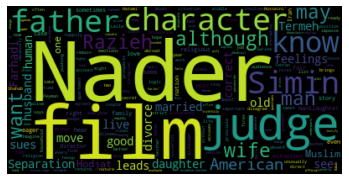

In [87]:
# Display the generated image:


plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

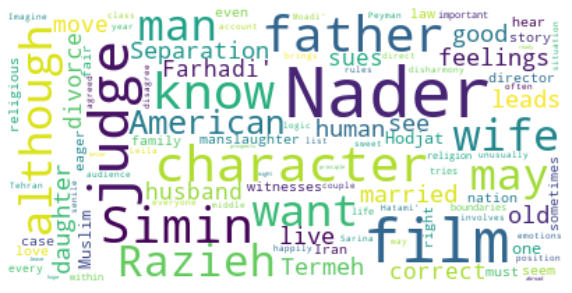

In [88]:
#Make required changes to the image

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize = [10,8])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [89]:
# Save the image in the local directory:

wordcloud.to_file("a_separation_review.png")

**Downloading movie posted using media wiki (wptools) API**

In [90]:
#accessing the wikipedia page

wiki_url = 'https://en.wikipedia.org/wiki/A_Separation'

page = wptools.page(wiki_url.split('/')[-1]).get()

en.wikipedia.org (query) A_Separation
en.wikipedia.org (query) A Separation (&plcontinue=30547958|0|Pri...
en.wikipedia.org (parse) 30547958
www.wikidata.org (wikidata) Q640561
www.wikidata.org (labels) P5032|Q6765759|Q22006653|P437|Q5940547|...
www.wikidata.org (labels) P462|P6145|Q3616|Q900414|P3302|P57|P240...
www.wikidata.org (labels) P161|Q907311|Q93190|P2638|Q16048111|Q81...
en.wikipedia.org (restbase) /page/summary/A_Separation
en.wikipedia.org (imageinfo) File:A Separation (2011 film poster).png
A Separation (en) data
{
  WARNINGS: <dict(1)> extracts
  aliases: <list(2)> Separation, The Separation of Nader from Simin
  assessments: <dict(2)> Film, Iran
  claims: <dict(93)> P344, P1476, P1040, P577, P31, P345, P57, P16...
  description: 2011 Iranian film
  exhtml: <str(570)> <p><i><b>A Separation</b></i> (also titled <i...
  exrest: <str(535)> A Separation (also titled Nader and Simin, A ...
  extext: <str(1229)> _**A Separation**_ (Persian: جدایی نادر از س...
  extract: <str(25

In [91]:
#extracting the poster image URL

image_url = page.data['image'][0]['url']

In [92]:
#downloading the image from the url and saving on local directory

r = requests.get(image_url)
i = Image.open(BytesIO(r.content))

i.save(wiki_url.split('/')[-1] + '_poster.' + image_url.split('.')[-1])

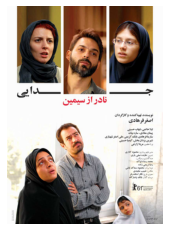

In [95]:
import matplotlib.image as mpimg
img = mpimg.imread('A_separation_poster.png')
imgplot = plt.imshow(img)
plt.imshow(img, cmap="Greys")
plt.axis("off")
plt.show()

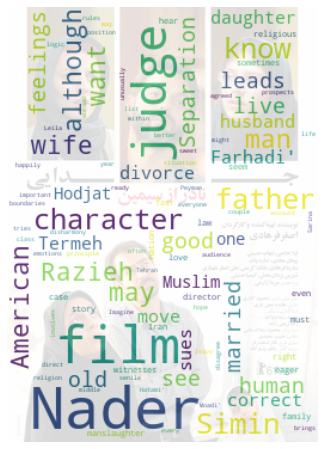

In [110]:
#overlapping the wordcloud and the movie poster

poster_mask = np.array(Image.open('A_separation_poster.png'))

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", mask = poster_mask).generate(text)
plt.figure(figsize = [10,8])
plt.imshow(wordcloud, interpolation="bilinear")
plt.imshow(img, cmap="Greys", alpha = 0.15)
plt.axis("off")
plt.show()